In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

from dataloader import DigitDataset
from utils import reshape, drawimg, tensor_to_pltimg, multidrawimg
#Test

ImportError: cannot import name 'drawing' from 'utils' (c:\Users\Jiyoon\python\2023winter-seminar\utils.py)

### Data Loader

In [2]:
trainfile = pd.read_csv('digit-recognizer/train.csv')
trainimg = [(np.reshape(row[1].values[1:],(28,28)),row[1].values[0]) for row in trainfile.iterrows()]

In [3]:
ds = DigitDataset('digit-recognizer/train.csv')
dl = DataLoader(dataset=ds, batch_size=16)



In [4]:
imgs, labels = next(iter(dl))

imgs.shape, labels.shape

(torch.Size([16, 28, 28]), torch.Size([16]))

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,]),
    transforms.RandomAdjustSharpness(10)]
    
    )

ds = DigitDataset('digit-recognizer/train.csv', transform)
dl = DataLoader(dataset=ds, batch_size=16)

imgs, labels = next(iter(dl))

imgs.shape, labels.shape
# multidrawimg(imgs, labels)

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

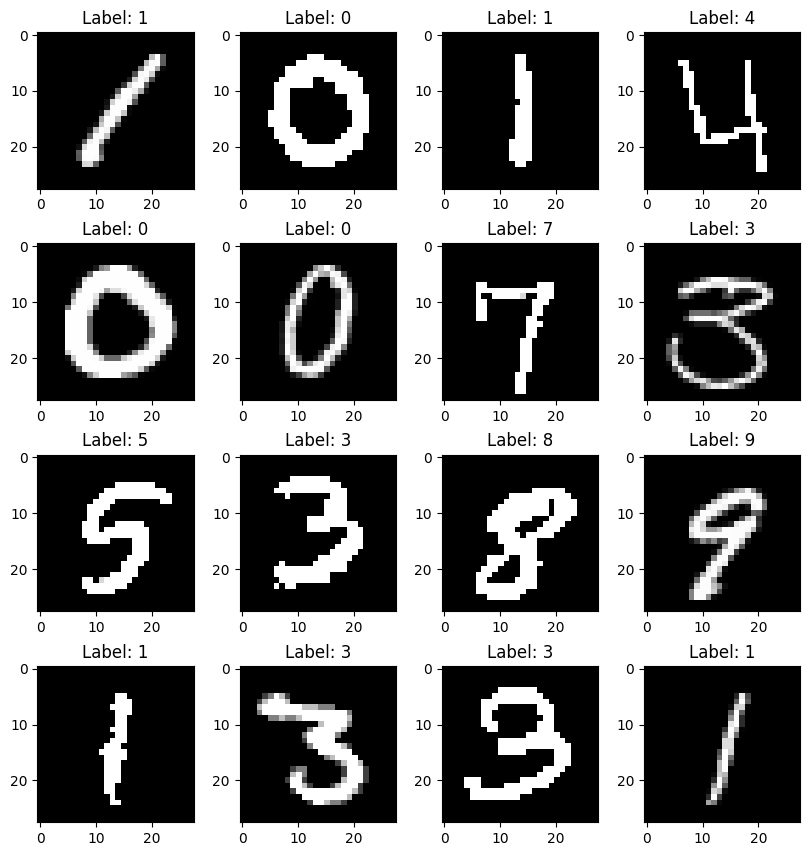

In [6]:
# imgs, labels = next(iter(dl))
# imgs = np.expand_dims(imgs, axis=-1)
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.5,], [0.5,]),
#     transforms.RandomAdjustSharpness(10)]
# )

multidrawimg(imgs, labels)

#이거 dataset class에 넣기!!

In [ ]:
ds = DigitDataset('digit-recognizer/train.csv')
dl = DataLoader(dataset=ds, batch_size=16)



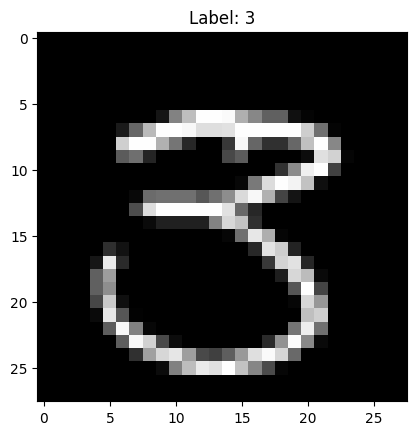

In [6]:
drawimg(ds[7])

In [10]:
imgs, labels = next(iter(dl))

imgs.shape, labels.shape

(torch.Size([16, 28, 28]), torch.Size([16]))

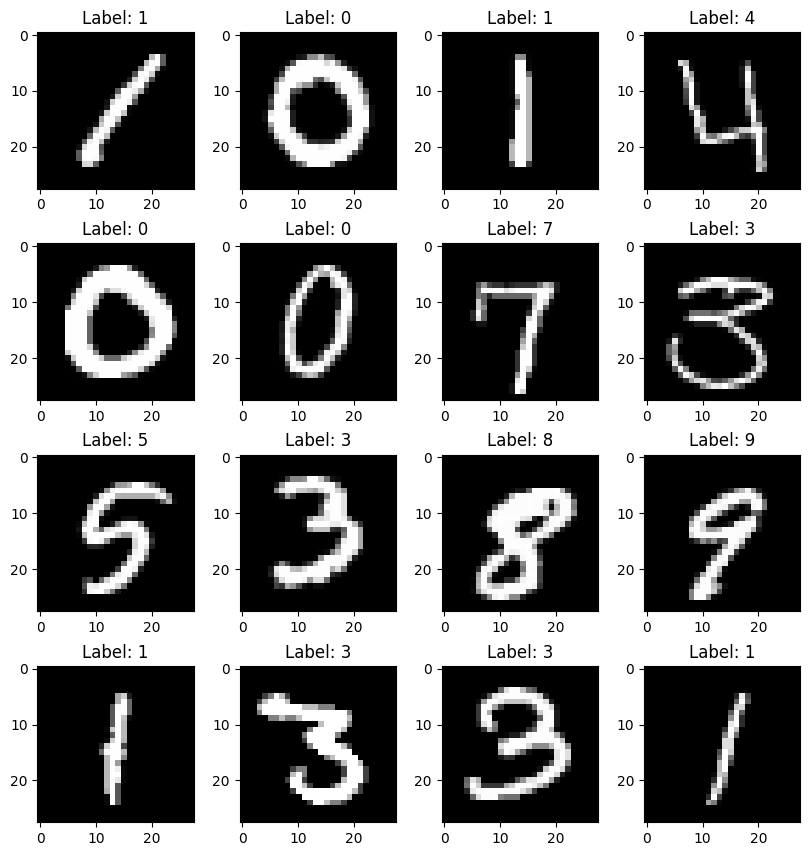

In [11]:
multidrawimg(imgs, labels)

    

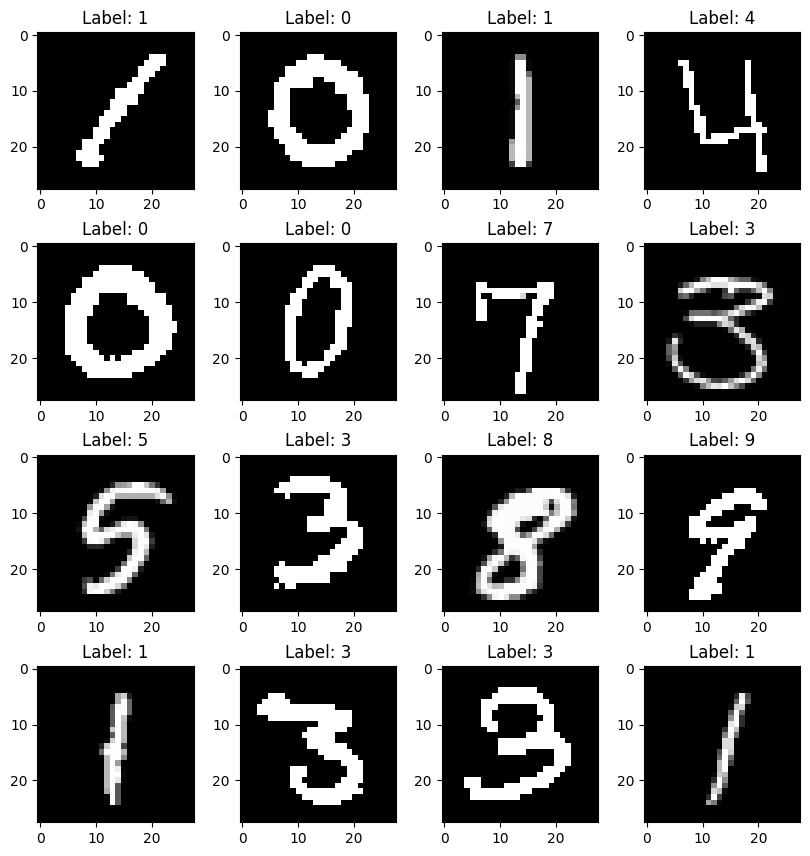

In [22]:
imgs, labels = next(iter(dl))
imgs = np.expand_dims(imgs, axis=-1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,]),
    transforms.RandomAdjustSharpness(10)]
)

multidrawimg(imgs, labels, transform=transform)

#이거 dataset class에 넣기!!

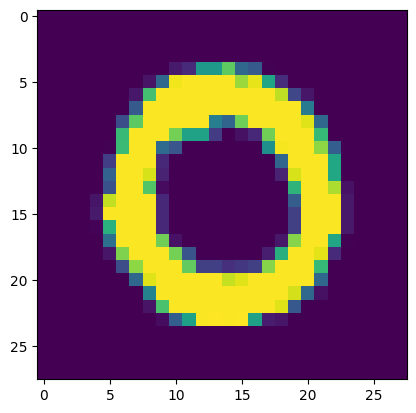

In [135]:
imgs, labels = next(iter(dl))
imgs = np.expand_dims(imgs, axis=-1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,], [0.5,])
])

plt.imshow(tensor_to_pltimg(transform(imgs[1].astype(float))))

In [93]:
imgs = np.expand_dims(imgs, axis=1)
transform = transforms.Normalize([0.5,],[0.5,])
transform(imgs[0])

TypeError: img should be Tensor Image. Got <class 'numpy.ndarray'>

In [77]:
imgs, labels = next(iter(dl))
imgs = np.expand_dims(imgs, axis=1)
imgs.shape

(16, 1, 28, 28)